# Análisis de la variación morfólogica de la Laguna de La Cocha y análisis de su batimetría

El siguiente análisis hace parte del trabajo de fin de máster presentado para el programa de Análisis de datos Masivos de la UAX.

**Objetivo:** explorar las herramientas del big data y la teledetección para los procesos de Ordenamiento Territorial Alrededor del Agua en la Región Hídrica del Valle de Atríz, Colombia.

En ese marco, el siguiente script contiene el análisis de la serie temporal de la dinámica morfológica de la Laguna de La Cocha, en términos de su extensión. Asi, se evidencia como con estas herramientas es posible hacer análisis territoriales de cuerpos de agua, que evidencien problemáticas de sequía, inundaciones, cambios en las capacidades de almacenamiento, entre otros.

**Área de estudio:**

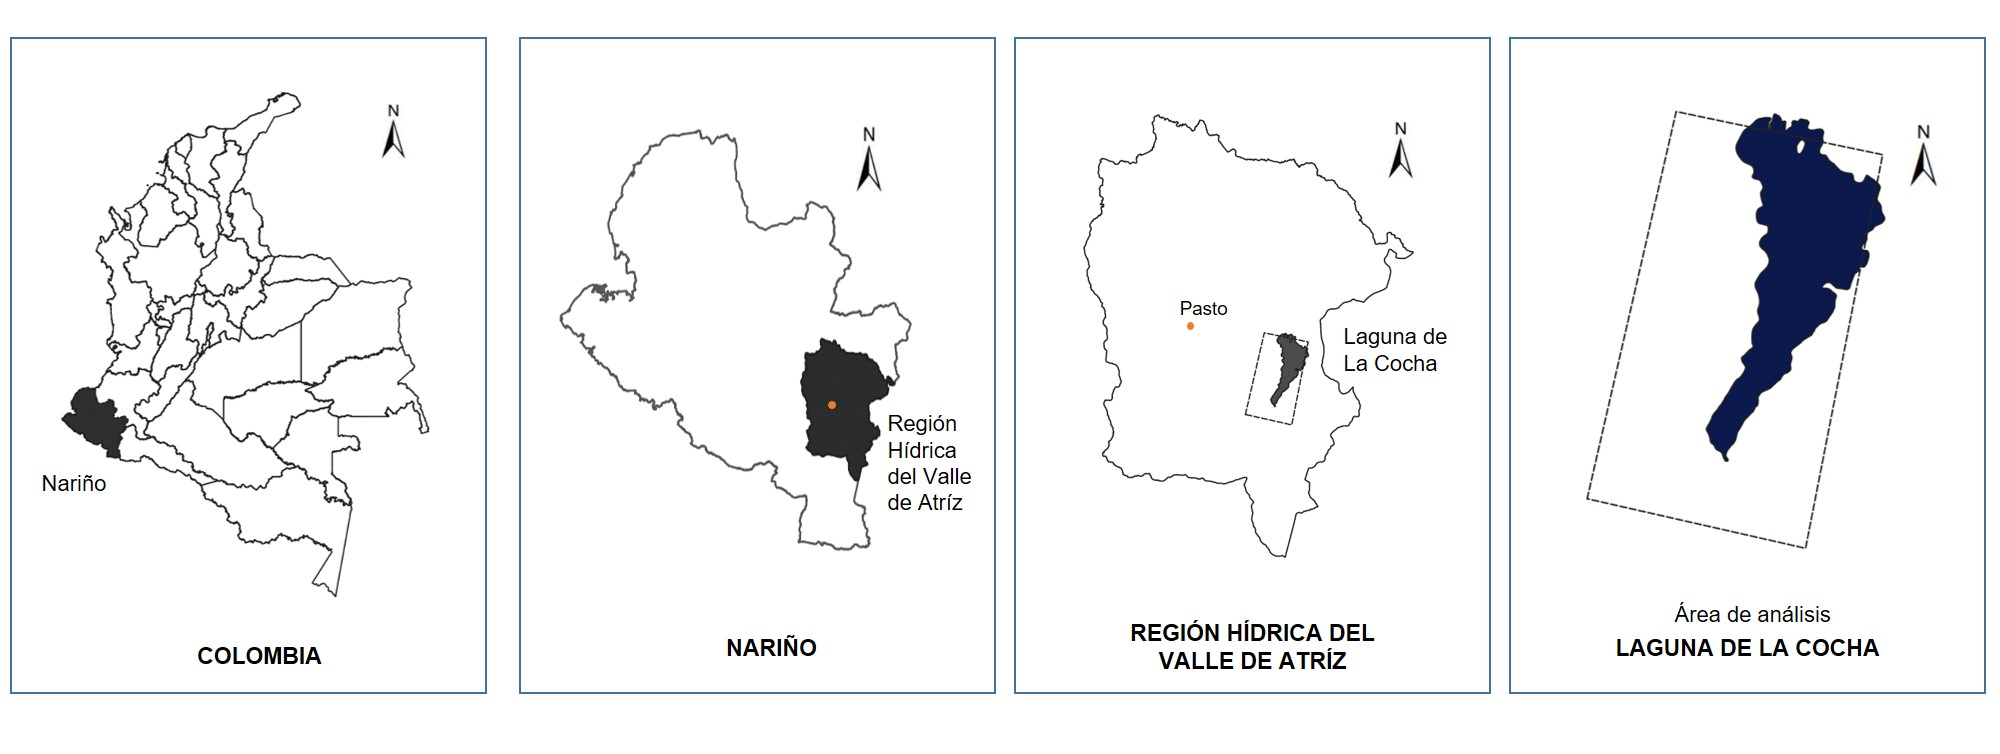

# Monitoreo de la superficie de agua de la Laguna de La Cocha en Nariño Colombia

El siguiente código ha sido adaptado del trabajo realizado por Bora (2024) en su artículo [Monitoring Inland Surface Water Area using Google Earth Engine & Python](https://medium.com/@kavyajeetbora/monitoring-inland-surface-water-area-using-google-earth-engine-python-35f938da8077), para llevar a cabo el análisis de la extensión de La Laguna de La Cocha ubicada en el departamento de Nariño, Colombia

## Configuración del entorno de trabajo

In [ ]:
# Instalación de paquetes

!pip install -q rioxarray
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.0 MB/s eta 0:00:00


In [ ]:
# Importación de módulos

import geemap
import ee
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
from IPython.display import Image as IpyImage
from PIL import Image, ImageFont, ImageDraw, ImageSequence
import rioxarray as rxr
import scipy as sp
import numpy as np
import plotly.graph_objects as go
import json
import os
import geopandas as gpd

In [ ]:
# Api GEE

ee.Authenticate()
ee.Initialize(project ='ee-rhva')

## Geometría del área de interés (AOI)

In [ ]:
# Definición de área de interés

aoi_geojson  = {
  "coordinates": [
    [
      [
        -77.2049604,
        1.1875262
      ],
      [
        -77.2152636,
        0.9943284
      ],
      [
        -77.0864735,
        0.999819
      ],
      [
        -77.0868169,
        1.1906145
      ],
      [
        -77.2049604,
        1.1875262
      ]
    ]
  ],
  "type": "Polygon"
}

geometry = ee.Geometry(aoi_geojson)

In [ ]:
# Guardar el GeoJSON en un archivo
with open("/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Data/aoi_geojson", "w") as f:
    json.dump(aoi_geojson, f)

print("GeoJSON guardado correctamente.")



GeoJSON guardado correctamente.


In [ ]:
# Conversión de GeoJson en shape

# Cargar el GeoJSON
gdf = gpd.read_file("/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Data/aoi_geojson")

# Especificar el directorio de salida donde se guardará el Shapefile
output_dir = "/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Data"

output_file_path = os.path.join(output_dir, "geometry_aoi.shp")
gdf.to_file(output_file_path)


## Descarga de los datos de superficie de agua del dataset JRC

[JRC Global Surface Water Data](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_YearlyHistory): Este dataset contiene mapas de la superficie del agua entre 1984 y 2021 con estadísticas de extensión. El dataset se compone de las siguientes bandas:

|Valor |Color|Descripción|
|-----|------|-------------|
|0|#cccccc|No data|
|1|#ffffff|Not water|
|2|#99d9ea|Seasonal water|
|3|#0000ff|Permanent water|



In [ ]:
# Extracción de datos del dataset para el área de estudio

image_collection = ee.ImageCollection("JRC/GSW1_4/YearlyHistory")\
.filter(ee.Filter.bounds(geometry))

In [ ]:
# Enmascaramiento de bandas de presencia de cuerpo de agua: 2 y 3

def maskSurfaceWater(image):
    new_image = image.eq(2).Or(image.eq(3)) #banda 2: agua temporal, banda 3: agua permanente
    return new_image.copyProperties(image, image.propertyNames())


# Aplicación de máscara a la colección de imágenes
masked_image_collection = image_collection.map(maskSurfaceWater)

## Visualización del dataset en el área de interes

In [ ]:
# Selección de una imagen de la colección para verificación en visualización
image_2000 = masked_image_collection.filter(ee.Filter.eq('year', 2000)).first()
isWaterImage = image_2000.selfMask()

Map = geemap.Map(basemap='HYBRID')
visParams = {'palette': ['blue']}
Map.addLayer(isWaterImage.clip(geometry), visParams, 'Laguna de La Cocha - 2000')
Map.centerObject(geometry, zoom=12)
Map

Map(center=[1.0916950225724142, -77.14852334607878], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Función de cálculo de área de la superficie del cuerpo de agua

def getWaterSurfaceArea(image):

    areaImage = image.multiply(ee.Image.pixelArea())
    totalArea = areaImage.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = geometry,
        scale=30,
        maxPixels = 1e10
    )

    totalArea = ee.Number(totalArea.get('waterClass')).divide(1e6).round()

    return image.set('area_km2', totalArea)

In [ ]:
# Aplicación de la función de cálculo de área para cada imagen

areaImages = masked_image_collection.map(getWaterSurfaceArea)

## Cálculo de serie temporal de la extensión de la laguna entre 1985 y 2021

In [ ]:
# Definición de la función de extracción de serie temporal del área del cuerpo de agua por año

def extract_time_series(image_collection, stat='area_km2'):

    image_list = image_collection.getInfo()['features']
    properties = [img['properties'] for img in image_list]

    xs, ys = [], []
    for prop in properties:
        x,y = prop['year'], prop[stat]
        xs.append(x), ys.append(y)

    return xs, ys

# Definición de función para plotear la serie temporal del área del cuerpo de aua

def plot_time_series(x,y):
    '''
    Plot the time series given the x - year, y - area for example
    and return a matplotlib figure
    '''

    fig,ax = plt.subplots(figsize=(15,3))
    ax.plot(x,y)
    ax.set_xlabel("Año")
    ax.set_ylabel('Superficie de agua (km2)')
    ax.set_title("Total de la superficie de agua (km2)")
    ax.set_ylim(0,max(y)*1.3)
    ax.grid(axis = 'x')
    return fig

    year  area_km2
0   1984         1
1   1985        34
2   1986        41
3   1987        34
5   1989        15
6   1990        18
7   1991        40
12  1996         4
13  1997         1
14  1998        15
15  1999        41
16  2000        41
17  2001        40
18  2002        32
19  2003        29
20  2004        26
21  2005        36
22  2006        27
23  2007        32
24  2008        39
25  2009        39
26  2010        38
27  2011        38
28  2012        35
29  2013        40
30  2014        40
31  2015        38
32  2016        41
33  2017        41
34  2018        41
35  2019        41
36  2020        40
37  2021        41


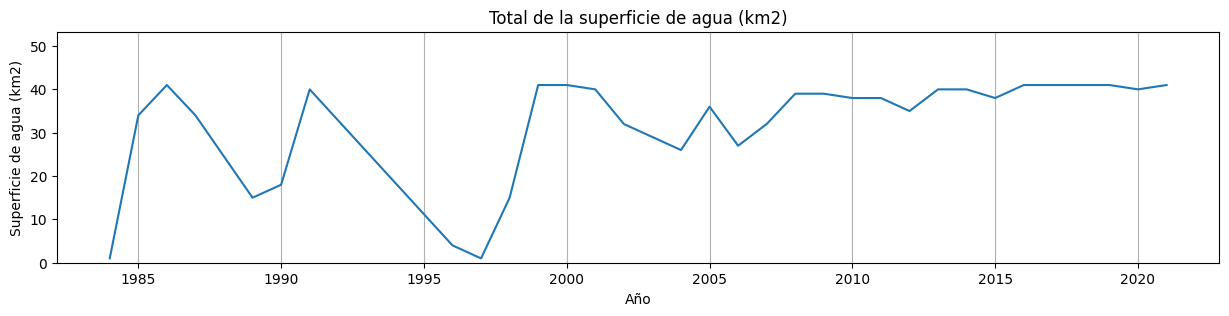

In [ ]:
# Aplicación de funciones definidas previamente

# Extracción de la serie temporal por año

xs,ys = extract_time_series(areaImages)

# Creación de un dataframe con la serie temporal

df = pd.DataFrame(zip(xs,ys), columns=['year','area_km2'])

# Remoción de valores nulos, cada valor número se convierte en 0

df = df[df['area_km2']>0]

# Ploteo de la serie temporal
fig = plot_time_series(df['year'],df['area_km2'])

#Impresión del dataframe de la serie temporal
print(df)

In [ ]:
# Descarga de dataframe de la serie tempoal

# Ruta de guardado
output_df= "/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/extension_la_cocha_time_series.csv"

# Guardar df como csv
df.to_csv(output_df, index=False)

print(f"DataFrame saved to: {output_df}")


DataFrame saved to: /content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/extension_la_cocha_time_series.csv


In [ ]:
# Guardar plot de la serie tempora

fig.savefig('/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/timeseries_water_surface_area.png', bbox_inches='tight')

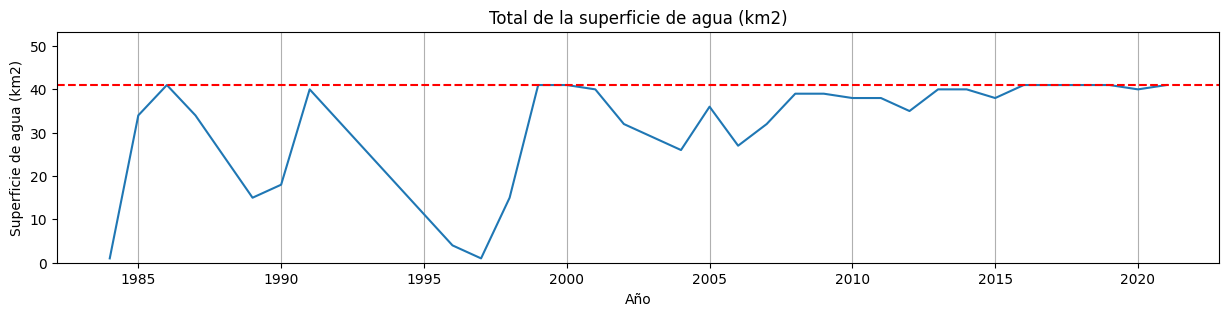

In [ ]:
# Ploteo de la serie con una línea horizontal de máximos valores

def plot_time_series_with_horizontal_line(x, y):
    """
    Plot the time series with a horizontal line that omits the drops.
    """
    fig, ax = plt.subplots(figsize=(15, 3))

    # Find the maximum value
    max_value = max(y)

    # Plot the data
    ax.plot(x, y)

    # Add a horizontal line at the maximum value
    ax.axhline(y=max_value, color='r', linestyle='--')

    # Set labels and title
    ax.set_xlabel("Año")
    ax.set_ylabel('Superficie de agua (km2)')
    ax.set_title("Total de la superficie de agua (km2)")

    # Set y-axis limits
    ax.set_ylim(0, max_value * 1.3)

    # Add gridlines
    ax.grid(axis='x')

    return fig

# Plotting the data
fig2 = plot_time_series_with_horizontal_line(df['year'], df['area_km2'])

# Display the plot
plt.show()

fig2.savefig('/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/timeseries_water_surface_area_maxline.png', bbox_inches='tight')


## Animación GIF de la dinámica temporal de la Laguna de La Cocha

Usando `.getVideoThumbURL()`

In [ ]:
# Remoción de valores nulos
image_collection = areaImages.filter(ee.Filter.gt('area_km2',0))

# Parámetros de visualización, paleta de colores sobre las bandas de agua
visParams = {
    'bands': 'waterClass',
    'palette': ['blue']
}

# Creación de la imagen para cada imagen de la colección con función map
images = image_collection.map(lambda image: image.visualize(min=0, max=1, palette=['black','blue']).selfMask())

## Definición de páramentros de visualización del GIF
gifParams = {
  'region': geometry,
  'dimensions': 600,
  'framesPerSecond': 1
}

# Descarga del gif

url = images.getVideoThumbURL(gifParams)
subprocess.run(["wget", url, "-O", "/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/surface_water.gif"])

CompletedProcess(args=['wget', 'https://earthengine.googleapis.com/v1/projects/ee-rhva/videoThumbnails/718414ba15ff22691895bdb72bab1b42-a51bd41fa1ef9d689c7d18ea85ea11e3:getPixels', '-O', '/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/surface_water.gif'], returncode=0)

## Mejora del GÏF agregando labels para cada año

Se usa un paquete PIL para modificar cada imagen del GIF y agregar una etiqueta del año correspondiente. Se descarga un tipo de fuente.tiff de AdobeFonts

In [ ]:
!wget https://github.com/adobe-fonts/source-sans/raw/release/TTF/SourceSans3-Black.ttf -O SourceSans3-Black.ttf ## descarga de tipo de fuente

--2024-08-27 16:57:23--  https://github.com/adobe-fonts/source-sans/raw/release/TTF/SourceSans3-Black.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adobe-fonts/source-sans/release/TTF/SourceSans3-Black.ttf [following]
--2024-08-27 16:57:23--  https://raw.githubusercontent.com/adobe-fonts/source-sans/release/TTF/SourceSans3-Black.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 422244 (412K) [application/octet-stream]
Saving to: ‘SourceSans3-Black.ttf’

SourceSans3-Black.t 100%[===================>] 412.35K  --.-KB/s    in 0.05s   

2024-08-27 16:57:23 (8.48 MB/s) - ‘SourceSans3-Black.tt

In [ ]:
# Función para agregar etiquetas a cada fotograma del gif

def label_gif_images(gif_file, labels, font_size=30):

    '''
    Input: gif file and list of labels
    Note: List of labels must be equal to the no. of frames in the gif file

    Saves the modified gif as 'new.gif` file
    '''
    gifImage = Image.open(gif_file) # Leer el GIF
    images = []  # Crear lista para almacenar imagenes modificadas

    for frame, label in zip(ImageSequence.Iterator(gifImage), labels):
        frame_image = frame.copy()
        canvas = ImageDraw.Draw(frame_image)

        # Personalizar la fuente
        font = ImageFont.truetype('SourceSans3-Black.ttf', font_size)

        # Add Text to an image
        w,h = gifImage.size
        txt_x, txt_y = int(0.5*w), int(0.01*h)
        canvas.text((txt_x, txt_y), f"Year: {label}", fill =(255, 0, 0), align ="center", font=font)
        images.append(frame_image)  # Agregación de imagenes

  # Guardar nuevo gif
    images[0].save(f"/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/surface_water_label.gif", append_images=images[1:], save_all=True)

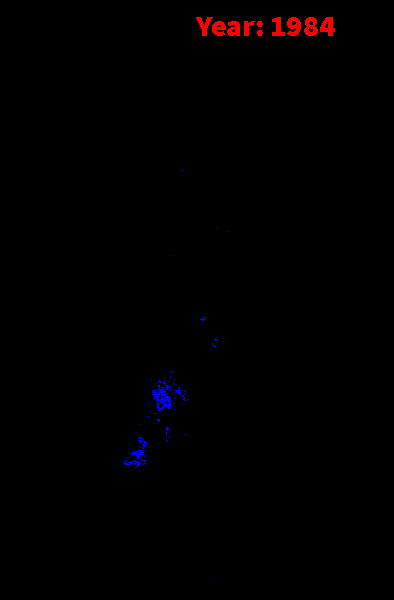

In [ ]:
# Agregar etiquetas al gif

label_gif_images("/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/surface_water.gif", df.year)
IpyImage("/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/surface_water_label.gif")

# Análisis de batimetría de la Laguna de La Cocha

En este ejercicio de estima el volumen de agua de la Laguna de La Cocha, así como su perfil batrimétrico (topográfico) de acuerdo con el conjunto de datos dispuesto por GloBathy en Google Earth Engine. Este conjunto de datos fue construido con datos de cuerpos de agua globales, y la máxima profundidas es estimada con una validación en 1503 cuerpos


Este ejercicio ha sido replicado del código construido por Bora (2024) en su
artículo [Unlocking the Depths: A Guide to Estimating Lake Volume with Google Earth Engine and Python](https://medium.com/@kavyajeetbora/unlocking-the-depths-a-guide-to-estimating-lake-volume-with-google-earth-engine-and-python-ef36b842fa2a)

## Descarga de datos GloBathy y visualización

In [ ]:
# Descarga de datos del dataset GloBathy

globathy = ee.Image("projects/sat-io/open-datasets/GLOBathy/GLOBathy_bathymetry")

# Enmascaramiento de la primera banda = profundidad
globathy = globathy.rename('Depth_m').unmask(0)

# Cálculo de área de pixel
area = globathy.gt(0).multiply(ee.Image.pixelArea()).rename('area_m2')

# Cálculo de volumen por pixel
volume = area.multiply(globathy).rename("volume_m3")

#Visualización

Map = geemap.Map(basemap='OpenTopoMap')
visParams = {"min": 0, "max": 30000, 'palette': ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']}
Map.addLayer(volume.clip(geometry), visParams, 'Global Bathymetry')
Map.centerObject(geometry, zoom=12)
Map

Map(center=[1.0916950225724142, -77.14852334607878], controls=(WidgetControl(options=['position', 'transparent…

## Estimación del volumen de agua de la laguna

In [ ]:
# Cálculo del volumen total de la Laguna

volume = volume.select("volume_m3")
totalVolume = volume.reduceRegion(
    reducer = ee.Reducer.sum(),
    geometry = geometry,
    scale=30,
    maxPixels = 1e10
)

totalVolume = ee.Number(totalVolume.get('volume_m3')).divide(1e6).round() #al dividir en 1e6 se convierte en millones de litros

total_volume_number = totalVolume.getInfo()

print(f"El total del volumen de la Laguna de La Cocha es de: {total_volume_number}" + " millones de litros")


El total del volumen de la Laguna de La Cocha es de: 510 millones de litros


In [ ]:

# Guardar valor total de volumen en Dataframe para su exportación csv

df_volume = pd.DataFrame({'volume_ml': [total_volume_number]})

# Ruta de descarga
output_volume = "/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/total_volume_la_cocha.csv"

# Guardar dataframe como csv
df_volume.to_csv(output_volume, index=False)

print(f"DataFrame saved to: {output_volume}")


DataFrame saved to: /content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/total_volume_la_cocha.csv


## Visualización 3D de Batimetría

In [ ]:
# Multiplica la profundidad de globathy por -1 para obtener globath_depths
globath_depths = globathy.multiply(-1)

# Especifica la ruta completa donde deseas guardar la imagen
output_path = "/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/Profundidad_LaCocha.tif"

# Exporta la imagen usando la ruta especificada
geemap.ee_export_image(
    globath_depths, filename=output_path, scale=30, region=geometry, file_per_band=False
)


Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/Profundidad_LaCocha.tif


In [ ]:
# Función para suavisar datos, convertirlos en xarray (archiva dimensiones, coordenadas)

def smoothen_dataArray(tif_file, sigma = 10):
    da = rxr.open_rasterio(filename=tif_file)
    da_vals = da.isel(band=0).values # zelección de la banda de profundidad
    # Aplica el filtro gaussiano a cada imagen
    sigma = [sigma, sigma] # Se asigna valores sigma del filtro a x, y
    z_smoothed = sp.ndimage.gaussian_filter(da_vals, sigma)

    da.data = np.expand_dims(z_smoothed, axis=0)
    return da

# Función para visualización 3D con el xarray
def plot_3D_terrain(xr_array):

    Z = xr_array.values
    Y = xr_array['y'].values
    X = xr_array['x'].values

    fig = go.Figure()

    fig.add_trace(
        go.Surface(
            z=Z,
            x=X,
            y=Y,
            colorscale = [
                # Let first 10% (0.1) of the values have color rgb(0, 0, 0)
                [0, "rgb(37, 0, 86)"],
                [0.1, "rgb(37, 0, 86)"],

                # Let values between 10-20% of the min and max of z
                # have color rgb(20, 20, 20)
                [0.1, "rgb(5, 0, 111)"],
                [0.2, "rgb(5, 0, 111)"],

                # Values between 20-30% of the min and max of z
                # have color rgb(40, 40, 40)
                [0.2, "rgb(0, 7, 129)"],
                [0.3, "rgb(0, 7, 129)"],

                [0.3, "rgb(0, 69, 172)"],
                [0.4, "rgb(0, 69, 172)"],

                [0.4, "rgb(0, 178, 192)"],
                [0.5, "rgb(0, 178, 192)"],

                [0.5, "rgb(0, 200, 182)"],
                [0.6, "rgb(0, 200, 182)"],

                [0.6, "rgb(0, 172, 115)"],
                [0.7, "rgb(0, 172, 115)"],

                [0.7, "rgb(0, 138, 56)"],
                [0.8, "rgb(0, 138, 56)"],

                [0.8, "rgb(0, 103, 12)"],
                [0.9, "rgb(0, 103, 12)"],

                [0.9, "rgb(18, 74, 0)"],
                [1.0, "rgb(18, 74, 0)"]
            ],
            hovertemplate ='<b>Depth</b>: %{z:.2f} m',
            name=""
        )
    )

    camera = dict(
        up=dict(x=0, y=0, z=1),
        eye=dict(x=1, y=1, z=1)
    )

    fig.update_layout(
        margin=dict(l=0, r=0, t=30, b=0),
        title = f"Topografía de la Laguna de La Cocha| Volumen total estimado {totalVolume.getInfo()} ML"
    )

    fig.update_xaxes(showticklabels=False, title='')
    fig.update_yaxes(showticklabels=False, title='')

    # se asigna escalas iguales a x,y y se asigna escala a z
    fig.update_scenes(aspectratio=dict(x=5, y=5,z=1))

    return fig

In [ ]:
#Descarga de xarray y visualización

ds = smoothen_dataArray('/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/Profundidad_LaCocha.tif', sigma=5)
da = ds.isel(band=0)
fig = plot_3D_terrain(da)


fig.show()

In [ ]:
# Extracción de la profundidad máxima de la laguna

max_depth = globathy.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=geometry,
    scale=30,
    maxPixels=1e10
)

# Obtener el valor máximo
max_depth_value = max_depth.get('Depth_m').getInfo()

print(f"La profundidad máxima de la laguna es: {max_depth_value} metros")


La profundidad máxima de la laguna es: 41.999900817871094 metros


In [ ]:

# Crear dataframe con el valor máximo de profundidad
df_max_depth = pd.DataFrame({'max_depth_m': [max_depth_value]})

#Ruta de descarga
output_max_depth = "/content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/max_depth_la_cocha.csv"

# Guarda dataframe como csv
df_max_depth.to_csv(output_max_depth, index=False)

print(f"DataFrame saved to: {output_max_depth}")


DataFrame saved to: /content/drive/MyDrive/TFM/Repositorio/1-water_monitoring/Results/max_depth_la_cocha.csv
